In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Dense, Flatten, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping
import pickle

# Set all seeds
np.random.seed(42)                        
tf.random.set_seed(42)                    
import random
random.seed(42)

# Force TensorFlow to use deterministic algorithms
tf.config.experimental.enable_op_determinism()

Training set shape: (50000, 28, 28, 1)
Validation set shape: (10000, 28, 28, 1)
Test set shape: (10000, 28, 28, 1)
Data type: float64

Min value: 0.0
Max value: 1.0
Mean value: 0.2862758283313326
Standard deviation: 0.3531853296234766

Unique labels: [0 1 2 3 4 5 6 7 8 9]
Label distribution in training set:
Class 0: Train: 5000, Val: 1000, Test: 1000 images
Class 1: Train: 5000, Val: 1000, Test: 1000 images
Class 2: Train: 5000, Val: 1000, Test: 1000 images
Class 3: Train: 5000, Val: 1000, Test: 1000 images
Class 4: Train: 5000, Val: 1000, Test: 1000 images
Class 5: Train: 5000, Val: 1000, Test: 1000 images
Class 6: Train: 5000, Val: 1000, Test: 1000 images
Class 7: Train: 5000, Val: 1000, Test: 1000 images
Class 8: Train: 5000, Val: 1000, Test: 1000 images
Class 9: Train: 5000, Val: 1000, Test: 1000 images

Sample image:


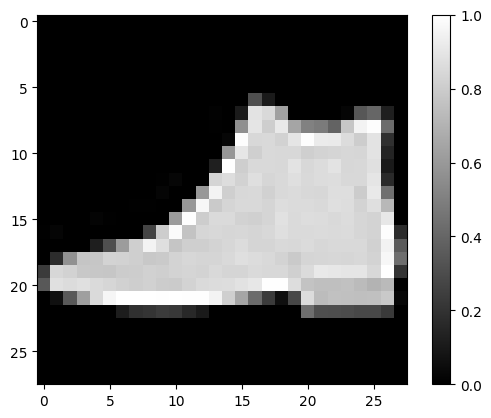

In [2]:
# Import the dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalize pixel values to [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# Add channel dimension
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Split x_train into train and validation sets while maintaining class distribution
x_train, x_val, y_train, y_val = train_test_split(
    x_train,
    y_train,
    test_size=1/6,
    random_state=42,
    stratify=y_train
)

# Display information about the dataset
print("Training set shape:", x_train.shape)
print("Validation set shape:", x_val.shape)
print("Test set shape:", x_test.shape)
print("Data type:", x_train.dtype)

print("\nMin value:", x_train.min())
print("Max value:", x_train.max())
print("Mean value:", x_train.mean())
print("Standard deviation:", x_train.std())

print("\nUnique labels:", np.unique(y_train))
print("Label distribution in training set:")
for i in range(10):
    print(f"Class {i}: Train: {np.sum(y_train == i)}, "
          f"Val: {np.sum(y_val == i)}, "
          f"Test: {np.sum(y_test == i)} images")

print("\nSample image:")
plt.imshow(x_train[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

In [3]:
def create_model(activation='tanh', optimizer='sgd'):
    model = Sequential([
        Input(shape=(28, 28, 1)),
        Conv2D(filters=6, kernel_size=5, activation=activation),
        AveragePooling2D(pool_size=2, strides=2),
        Conv2D(filters=16, kernel_size=5, activation=activation),
        AveragePooling2D(pool_size=2, strides=2),
        Conv2D(filters=120, kernel_size=4, activation=activation),
        Flatten(),
        Dense(84, activation=activation),
        Dense(10, activation='softmax')
    ], name=f'LeNet5_{activation}_{optimizer}', )
    
    if optimizer == 'sgd':
        opt = SGD(learning_rate=0.01, momentum=0.9)
    else:
        opt = optimizer  # e.g., 'adam'
        
    model.compile(
        optimizer=opt,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [4]:
# Initialize the sequential model
model = create_model(activation='tanh', optimizer='sgd')
model.summary()

/home/dkat/courses/computer-vision/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1730220100.423664   50631 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730220100.436349   50631 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730220100.436384   50631 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730220100.438239  

Model: "LeNet5_tanh_sgd"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 24, 24, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 12, 12, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 16)       │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 4, 4, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 1, 1, 120)      │        30,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,426 (173.54 KB)

 Trainable params: 44,426 (173.54 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',      
    patience=5,              
    restore_best_weights=True,  
    verbose=1,
    min_delta=0.0001,
    mode='min'               
)

# Training parameters
BATCH_SIZE = 32
EPOCHS = 20

# Train the model
history = model.fit(
    x_train,
    y_train, 
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
print(f'\nTest accuracy: {test_accuracy:.4f}')

model.save_weights('results/lenet5_tanh_sgd.weights.h5')

with open('results/history_tanh_sgd.pkl', 'wb') as file:
    pickle.dump(history.history, file)

Epoch 1/20


I0000 00:00:1730220102.079817   50753 service.cc:146] XLA service 0x7f83b4016480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730220102.079844   50753 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-10-29 16:41:42.094324: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-29 16:41:42.136903: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  95/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3416 - loss: 1.8008

I0000 00:00:1730220102.839258   50753 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6865 - loss: 0.8343 - val_accuracy: 0.8458 - val_loss: 0.4341
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8407 - loss: 0.4332 - val_accuracy: 0.8646 - val_loss: 0.3786
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8616 - loss: 0.3751 - val_accuracy: 0.8736 - val_loss: 0.3504
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8735 - loss: 0.3419 - val_accuracy: 0.8775 - val_loss: 0.3332
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8811 - loss: 0.3183 - val_accuracy: 0.8808 - val_loss: 0.3236
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8888 - loss: 0.2999 - val_accuracy: 0.8834 - val_loss: 0.3176
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8956 - loss: 0.2843 - val_accuracy: 0.8860 - val_loss: 0.3139
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ -0s -27us/step - accuracy: 0.9005 - loss: 0.2706 - val_accu

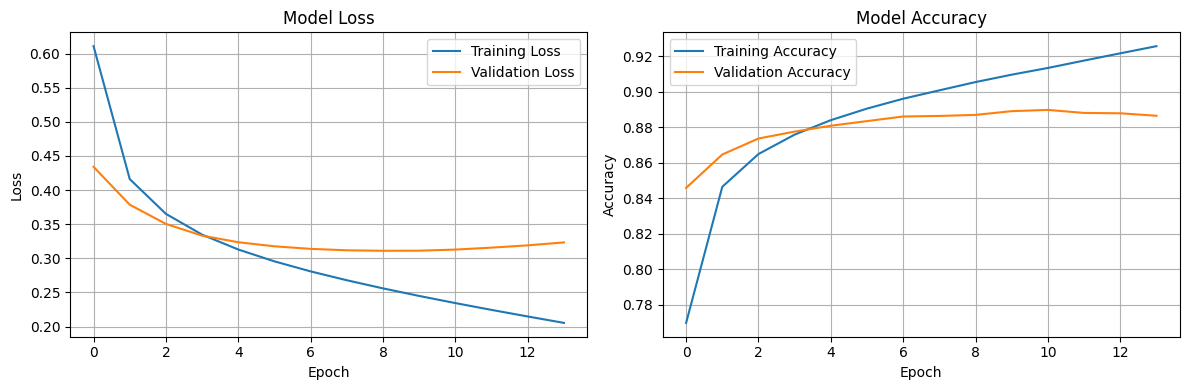

In [6]:
# Create a figure with two subplots side by side
plt.figure(figsize=(12, 4))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

Epoch 1/20


/home/dkat/courses/computer-vision/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6790 - loss: 0.8655 - val_accuracy: 0.8358 - val_loss: 0.4604
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 21us/step - accuracy: 0.8302 - loss: 0.4593 - val_accuracy: 0.8618 - val_loss: 0.3836
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8570 - loss: 0.3873 - val_accuracy: 0.8763 - val_loss: 0.3471
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8695 - loss: 0.3482 - val_accuracy: 0.8825 - val_loss: 0.3241
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8797 - loss: 0.3205 - val_accuracy: 0.8904 - val_loss: 0.3052
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8877 - loss: 0.2989 - val_accuracy: 0.8923 - val_loss: 0.2974
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8947 - loss: 0.2813 - val_accuracy: 0.8946 - val_loss: 0.2915
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9009 - loss: 0.2659 - val_accura

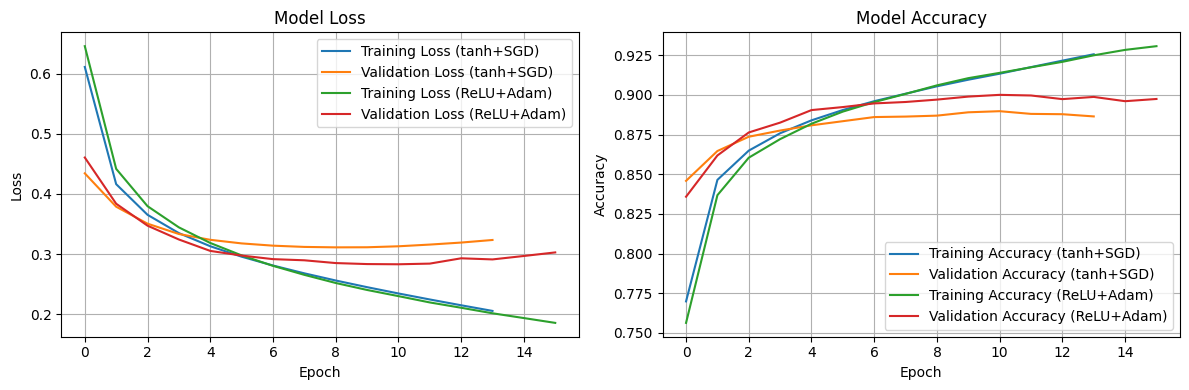

In [9]:
# Create new model with ReLU and Adam
model_relu = create_model(activation='relu', optimizer='adam')

# Train with same parameters as before
history_relu = model_relu.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

model_relu.save_weights('results/lenet5_relu_adam.weights.h5')

with open('results/history_relu_adam.pkl', 'wb') as file:
    pickle.dump(history_relu.history, file)

# Plot both histories for comparison
plt.figure(figsize=(12, 4))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss (tanh+SGD)')
plt.plot(history.history['val_loss'], label='Validation Loss (tanh+SGD)')
plt.plot(history_relu.history['loss'], label='Training Loss (ReLU+Adam)')
plt.plot(history_relu.history['val_loss'], label='Validation Loss (ReLU+Adam)')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy (tanh+SGD)')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy (tanh+SGD)')
plt.plot(history_relu.history['accuracy'], label='Training Accuracy (ReLU+Adam)')
plt.plot(history_relu.history['val_accuracy'], label='Validation Accuracy (ReLU+Adam)')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

# Modify the model creation function
def create_model(meta, learning_rate=0.001):
    model = Sequential([
        Input(shape=(28, 28, 1)),
        Conv2D(filters=6, kernel_size=5, activation='relu'),
        AveragePooling2D(pool_size=2, strides=2),
        Conv2D(filters=16, kernel_size=5, activation='relu'),
        AveragePooling2D(pool_size=2, strides=2),
        Conv2D(filters=120, kernel_size=4, activation='relu'),
        Flatten(),
        Dense(84, activation='relu'),
        Dense(10, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Create the KerasClassifier
model = KerasClassifier(
    model=create_model,
    learning_rate=0.001,  # default value
    epochs=20,
    batch_size=32,
    verbose=0
)

# Define parameter grid
param_grid = {
    'model__learning_rate': [0.001, 0.0005, 0.0001],  # Note the 'model__' prefix
    'batch_size': [64, 128, 256],
    'epochs': [15, 20, 25]
}

# Create and run GridSearchCV
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    verbose=2
)

# 5. Fit the grid search
grid_result = grid.fit(x_train, y_train)

In [17]:
# 6. Print results
print("\nBest parameters found:", grid_result.best_params_)
print("\nBest cross-validation score:", grid_result.best_score_)

# 7. Get detailed results for all combinations
for mean_score, params in zip(grid_result.cv_results_['mean_test_score'], 
                            grid_result.cv_results_['params']):
    print(f"\nParameters: {params}")
    print(f"Mean validation score: {mean_score}")


Best parameters found: {'batch_size': 64, 'epochs': 25, 'model__learning_rate': 0.0005}

Best cross-validation score: 0.89214

Parameters: {'batch_size': 64, 'epochs': 15, 'model__learning_rate': 0.001}
Mean validation score: 0.8886200000000001

Parameters: {'batch_size': 64, 'epochs': 15, 'model__learning_rate': 0.0005}
Mean validation score: 0.8812

Parameters: {'batch_size': 64, 'epochs': 15, 'model__learning_rate': 0.0001}
Mean validation score: 0.8295199999999999

Parameters: {'batch_size': 64, 'epochs': 20, 'model__learning_rate': 0.001}
Mean validation score: 0.89032

Parameters: {'batch_size': 64, 'epochs': 20, 'model__learning_rate': 0.0005}
Mean validation score: 0.8902599999999999

Parameters: {'batch_size': 64, 'epochs': 20, 'model__learning_rate': 0.0001}
Mean validation score: 0.8430199999999999

Parameters: {'batch_size': 64, 'epochs': 25, 'model__learning_rate': 0.001}
Mean validation score: 0.89056

Parameters: {'batch_size': 64, 'epochs': 25, 'model__learning_rate': 